In [2]:
import pandas as pd
from sklearn.datasets import make_blobs

centers = [[1, 1, 1, 1], [-1, -1, -1, -1], [-1, +1, -1, +1]]
n_features = 4
n_classes = 3
n_samples = 100
random_state = 20

X, y = make_blobs(n_samples=3*n_samples, n_features=n_features, centers=centers, random_state=random_state)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['class'] = y

def print_cls_shape(df):
    for cls in range(n_classes):
        num_cls = df[df['class'] == cls].shape[0]
        print(f'Num elements of class {cls}: {num_cls}')

print_cls_shape(df)

Num elements of class 0: 100
Num elements of class 1: 100
Num elements of class 2: 100


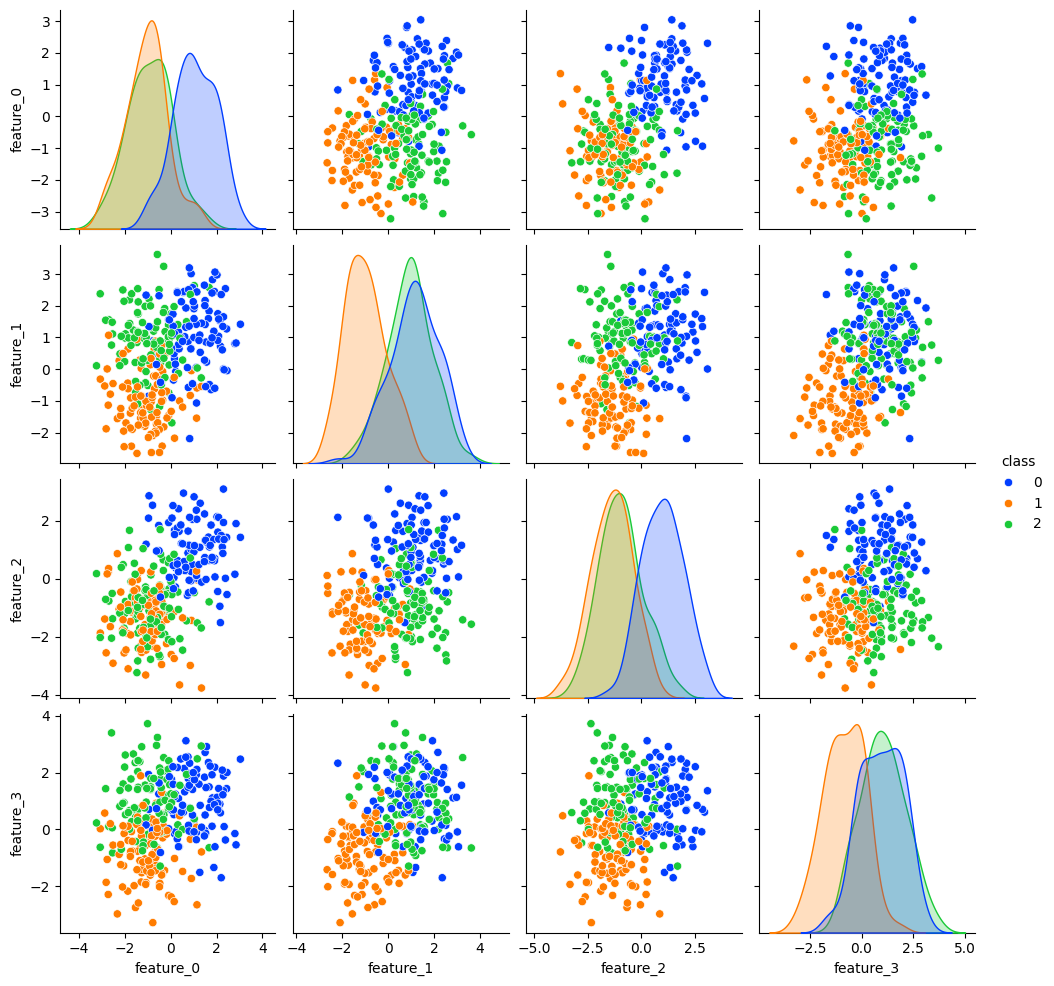

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

pair_plot = sns.pairplot(df, hue='class', palette='bright')
plt.show()

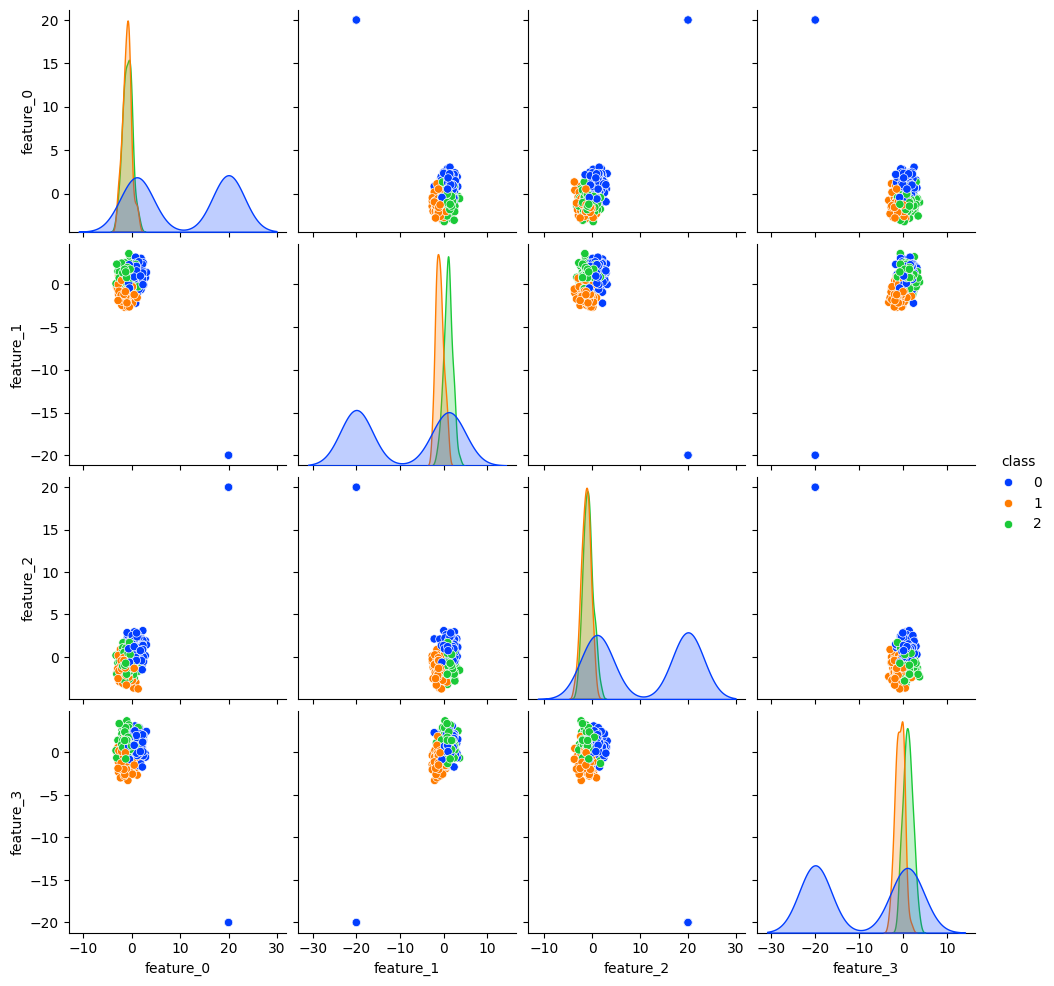

In [4]:
A = [1, 10, 100]
B = [5, 10, 20]


df_A_B = {}
df_A_B["df_0_0"] = df

for a in A:
    for b in B:
        X, y = make_blobs(n_samples=a, n_features=n_features, centers=[[b, -b, b, -b]], random_state=random_state, cluster_std=0)
        df_temp = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
        df_temp['class'] = y
        df_A_B[f'df_{a}_{b}'] = pd.concat([df, df_temp])

pair_plot = sns.pairplot(df_A_B["df_100_20"], hue='class', palette='bright')
plt.show()

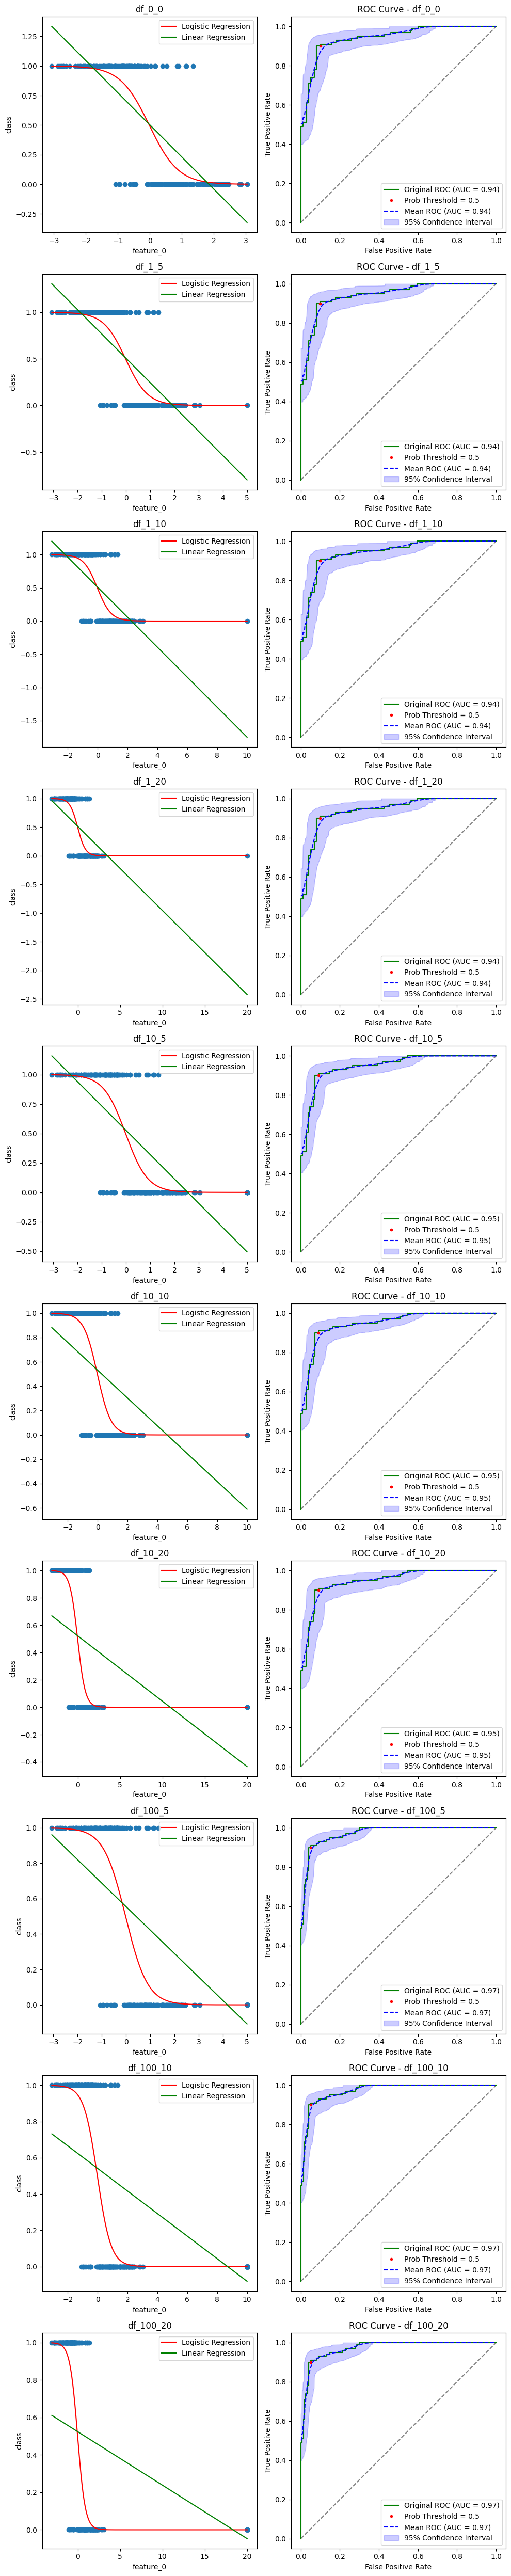

In [5]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_bootstrap_roc(model, X, y, ax, n_bootstraps=1000, ci=95):
    threshold = 0.5
    bootstrapped_scores = []
    all_fpr = np.linspace(0, 1, 1000)  
    tpr_list = []

    y_prob = model.predict_proba(X)[:, 1]

    fpr_full, tpr_full, thresholds_full = roc_curve(y, y_prob)
    auc_full = auc(fpr_full, tpr_full)

    threshold_idx_full = np.argmin(np.abs(thresholds_full - threshold))
    fpr_at_threshold = fpr_full[threshold_idx_full]
    tpr_at_threshold = tpr_full[threshold_idx_full]
    
    for _ in range(n_bootstraps):
        indices = np.random.randint(0, len(y), len(y)) 
        y_bootstrap = y[indices]
        
        fpr, tpr, _ = roc_curve(y_bootstrap, y_prob[indices])
        
        fpr = np.insert(fpr, 0, 0)
        tpr = np.insert(tpr, 0, 0)

        roc_auc = auc(fpr, tpr)
        bootstrapped_scores.append(roc_auc)

        tpr_list.append(np.interp(all_fpr, fpr, tpr))

    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)
    lower_tpr = np.percentile(tpr_list, (100 - ci) / 2, axis=0)
    upper_tpr = np.percentile(tpr_list, 100 - (100 - ci) / 2, axis=0)

    ax.plot(fpr_full, tpr_full, color='green', label=f'Original ROC (AUC = {auc_full:.2f})')
    ax.plot(fpr_at_threshold, tpr_at_threshold, 'ro', label=f'Prob Threshold = {threshold}', markersize=3)

    ax.plot(all_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linestyle='--')
    ax.fill_between(all_fpr, lower_tpr, upper_tpr, color='blue', alpha=0.2, label=f'{ci}% Confidence Interval')




classes = [0, 1]
feature = 'feature_0'

model_linear = LinearRegression()
model_logreg = LogisticRegression()

num_plots = len(df_A_B)

fig, axes = plt.subplots(num_plots, 2, figsize=(10, num_plots * 5))

axes = np.array(axes) if num_plots > 1 else np.reshape(axes, (1, 2))

for i, (name, data_frame) in enumerate(df_A_B.items()):
    df_filtered = data_frame[data_frame['class'].isin(classes)].reset_index(drop=True)
    df_filtered = df_filtered[[feature, 'class']]
    X, y = df_filtered.drop('class', axis=1).to_numpy(), df_filtered['class'].to_numpy()

    model_linear.fit(X, y)
    model_logreg.fit(X, y)
    
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    ax1.scatter(X, y)
    
    X_sorted = np.sort(X, axis=0)
    intervals = (np.min(X_sorted, axis=0), np.max(X_sorted, axis=0))
    X_line = np.linspace(intervals[0], intervals[1], 1000).reshape(-1, 1)
    
    y_logreg_pred = model_logreg.predict_proba(X_line)[:, 1]
    ax1.plot(X_line, y_logreg_pred, color='red', label='Logistic Regression')

    y_linear_pred = model_linear.predict(X_line)
    ax1.plot(X_line, y_linear_pred, color='green', label='Linear Regression')
    
    ax1.set_title(name)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('class')
    ax1.legend()
    
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve - {name}')

    plot_bootstrap_roc(model_logreg, X, y, ax2)

    ax2.legend()

plt.tight_layout()
plt.show()


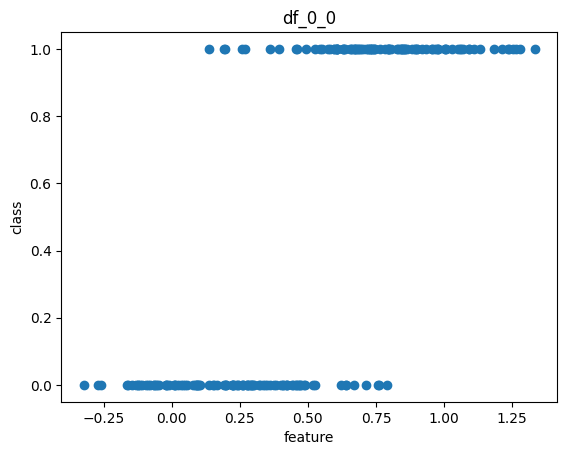

In [6]:
model = LinearRegression()

logdf_A_B = {}

for i, (name, data_frame) in enumerate(df_A_B.items()):
    df_filtered = data_frame[data_frame['class'].isin(classes)].reset_index(drop=True)
    df_filtered = df_filtered[[feature, 'class']]
    X, y = df_filtered.drop('class', axis=1).to_numpy(), df_filtered['class'].to_numpy()

    model.fit(X, y)

    logdf_A_B[name] = pd.DataFrame({'feature': model.predict(X), 'class': y})

name = 'df_0_0'
draw_df = logdf_A_B['df_0_0']
plt.title(name)
plt.xlabel('feature')
plt.ylabel('class')
plt.scatter(draw_df['feature'], draw_df['class'])

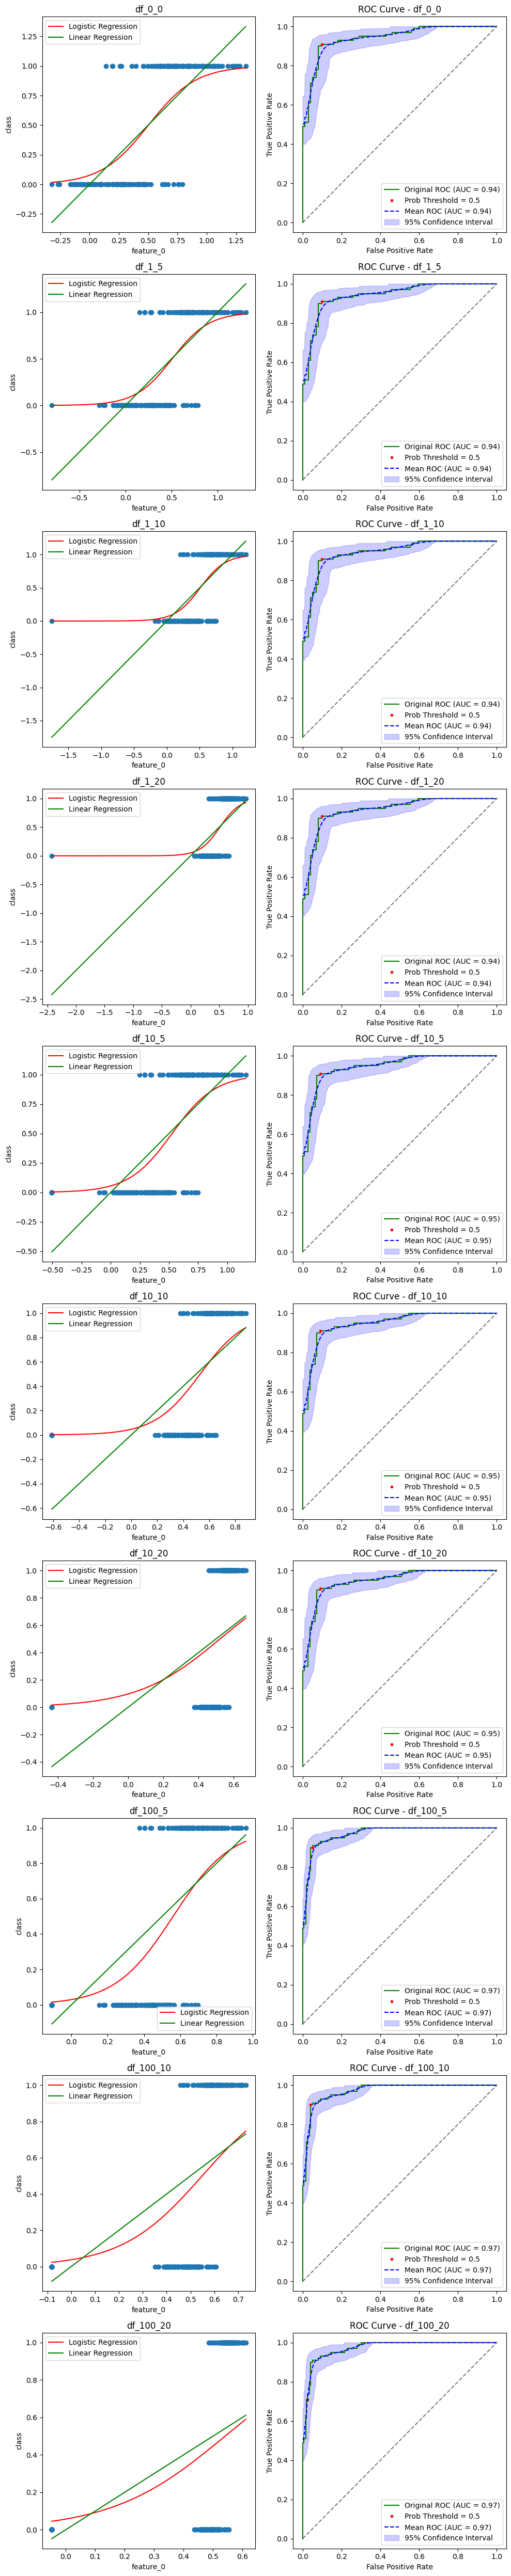

In [7]:
model_linear = LinearRegression()
model_logreg = LogisticRegression()

num_plots = len(df_A_B)

fig, axes = plt.subplots(num_plots, 2, figsize=(10, num_plots * 5))
axes = np.array(axes) if num_plots > 1 else np.reshape(axes, (1, 2))

for i, (name, data_frame) in enumerate(logdf_A_B.items()):
    df_filtered = data_frame[data_frame['class'].isin(classes)].reset_index(drop=True)
    X, y = df_filtered.drop('class', axis=1).to_numpy(), df_filtered['class'].to_numpy()

    model_linear.fit(X, y)
    model_logreg.fit(X, y)
    
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    ax1.scatter(X, y)
    
    X_sorted = np.sort(X, axis=0)
    intervals = (np.min(X_sorted, axis=0), np.max(X_sorted, axis=0))
    X_line = np.linspace(intervals[0], intervals[1], 1000).reshape(-1, 1)
    
    y_logreg_pred = model_logreg.predict_proba(X_line)[:, 1]
    ax1.plot(X_line, y_logreg_pred, color='red', label='Logistic Regression')

    y_linear_pred = model_linear.predict(X_line)
    ax1.plot(X_line, y_linear_pred, color='green', label='Linear Regression')
    
    ax1.set_title(name)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('class')
    ax1.legend()
    
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve - {name}')

    plot_bootstrap_roc(model_logreg, X, y, ax2)

    ax2.legend()

plt.tight_layout()
plt.show()

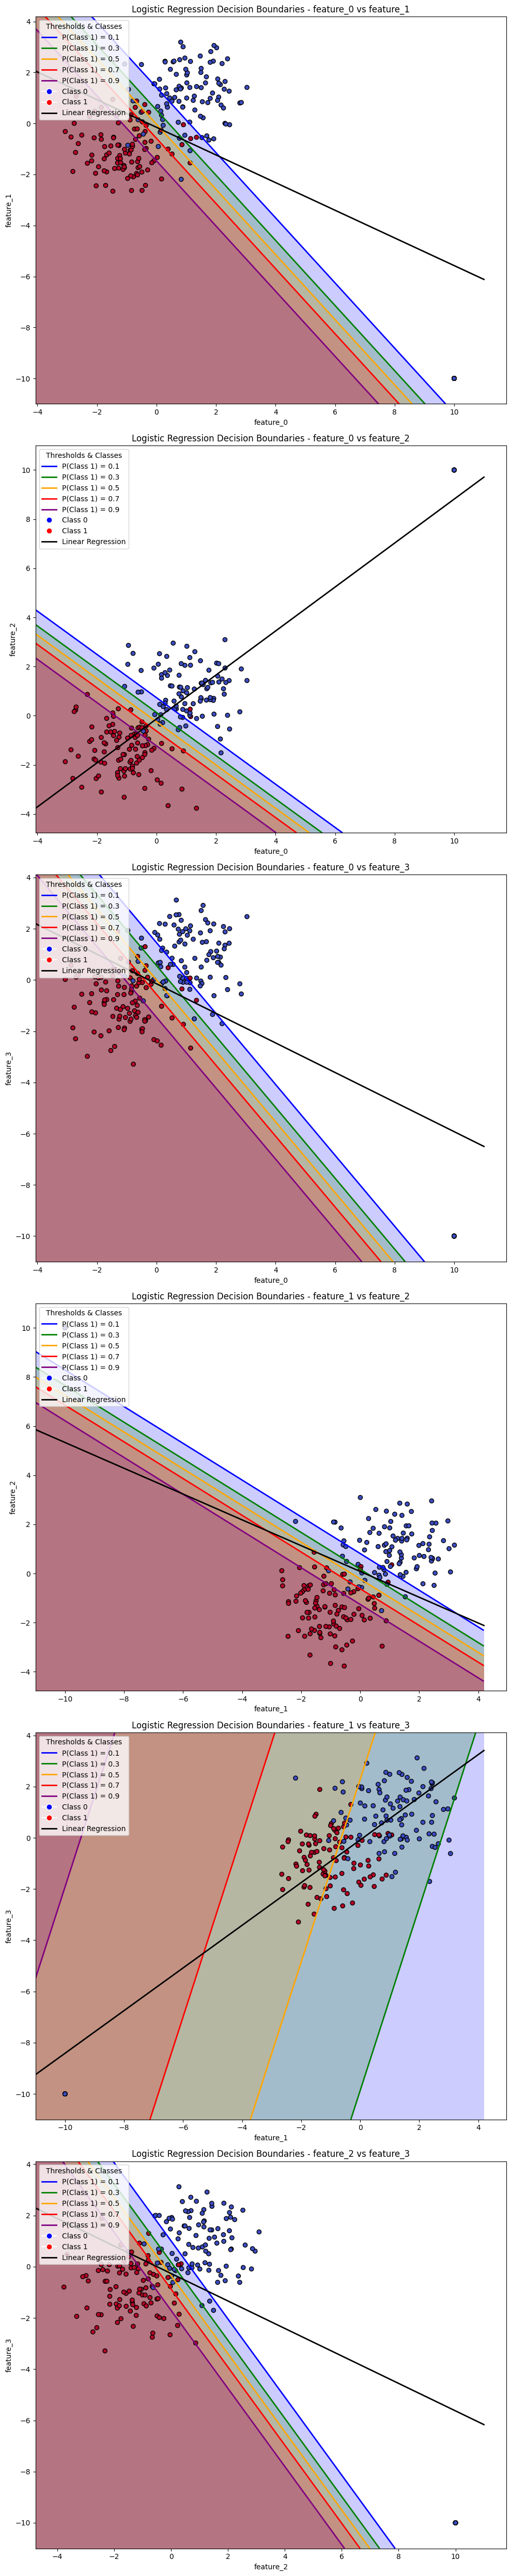

In [ ]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression

df_curr = df_A_B['df_10_10']
df_curr = df_curr[df_curr['class'].isin(classes)]

log_model = LogisticRegression()
lin_model = LinearRegression()

features = df_curr.columns[:-1]

X = df_curr[features].values
y = df_curr['class'].values

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = ['blue', 'green', 'orange', 'red', 'purple']  
fig, axes = plt.subplots(len(list(combinations(features, 2))), figsize=(10, 50))

for idx, (feature1, feature2) in enumerate(combinations(features, 2)):
    ax = axes[idx]
    X_pair = df_curr[[feature1, feature2]].values
    log_model.fit(X_pair, y)

    x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
    y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    probabilities = log_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    probabilities = probabilities[:, 1].reshape(xx.shape) 

    for i, threshold in enumerate(thresholds):
        ax.contourf(xx, yy, probabilities, levels=[threshold, 1], colors=[colors[i]], alpha=0.2)

    for i, threshold in enumerate(thresholds):
        ax.contour(xx, yy, probabilities, levels=[threshold], linewidths=2, colors=[colors[i]])

    lin_model.fit(X_pair[:, 0].reshape(-1, 1), X_pair[:, 1])
    line_x = np.array([x_min, x_max]).reshape(-1, 1)
    line_y = lin_model.predict(line_x)
    ax.plot(line_x, line_y, color="black", linestyle="--", linewidth=2, label="Linear Regression")

    scatter = ax.scatter(X_pair[:, 0], X_pair[:, 1], c=y, marker='o', cmap='coolwarm', edgecolors='k')

    ax.set_title(f'Logistic Regression Decision Boundaries - {feature1} vs {feature2}')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

    handles = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(thresholds))]
    labels = [f'P(Class 1) = {thresholds[i]:.1f}' for i in range(len(thresholds))]

    class_labels = [f'Class {i}' for i in np.unique(y)]
    class_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue' if i == 0 else 'red', markersize=8) for i in range(len(np.unique(y)))]

    ax.legend(handles + class_handles + [plt.Line2D([0], [0], color="black", lw=2)], 
              labels + class_labels + ["Linear Regression"], title="Thresholds & Classes", loc='upper left')

plt.tight_layout()
plt.show()
